In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!CUDA_LAUNCH_BLOCKING=1

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

In [4]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
from three_d_shapes_ds import ThreeDShapes
trainloader = torch.utils.data.DataLoader(
                                      ThreeDShapes(transform=torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((32, 32)),
                                        torchvision.transforms.ToTensor(),
                                      ]), filtered = True),
                                      batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(
                                      ThreeDShapes(transform=torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((32, 32)),
                                        torchvision.transforms.ToTensor(),
                                      ]), filtered = True),
                                      batch_size=32, shuffle=True)

In [6]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# change the number of classes 
vgg16.classifier[6].out_features = 16
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = True

In [8]:
from models import DisentangledLinear, BlockDropout

n_classes = 16

ncc = 2 #number of connected components

#vgg16.classifier[3] = DisentangledLinear(vgg16.classifier[3].in_features, vgg16.classifier[3].out_features).to(device)
#vgg16.classifier[6] = DisentangledLinear(vgg16.classifier[6].in_features, n_classes).to(device)

vgg16.classifier[3] = DisentangledLinear(vgg16.classifier[3].in_features, 200).to(device)
vgg16.classifier[6] = DisentangledLinear(200, n_classes).to(device)
vgg16.classifier[5] = BlockDropout(vgg16.classifier[6], ncc=ncc, p=0.8, apply_to="in")

# disentangle layers right after convolutions
# vgg16.classifier[0] = DisentangledLinear(vgg16.classifier[0].in_features, vgg16.classifier[0].out_features).to(device)
# vgg16.classifier[3] = DisentangledLinear(vgg16.classifier[3].in_features, vgg16.classifier[3].out_features).to(device)

# vgg16.classifier[2] = BlockDropout(vgg16.classifier[3], ncc=ncc, p=0.1, apply_to="in")

for param in vgg16.features.parameters():
    param.requires_grad = True

In [9]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
# optimizer
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()

In [11]:
def target_vec_to_class(vec):
    labels = (vec[:, 0] == 0).int()*(2**3) + (vec[:, 1] == 0).int()*(2**2) + (vec[:, 2] == 0)*2 + (vec[:, 4] == 0)
    return labels.long()

In [12]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0], data[1]
        target = target_vec_to_class(target)
                
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

In [13]:
def neuron_wise_br(model, layer, blocks, examples, ncc):
    model.eval()
    relative_error = [None]*layer.out_features
    for n in range(layer.out_features):
        mask = torch.ones(layer.out_features, dtype=torch.bool, device=device)
        mask[n] = 0
        a_n = normalize_w(layer.weight[mask])
        _, s, _ = torch.svd(a_n)
        relative_error[n] = ncc - torch.sum(s[ncc]).detach().cpu()
    return relative_error

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_blocked_weights(layer):
    plt.figure(figsize=(20, 7))
    blocks_in = compute_layer_blocks_in(layer, ncc)
    blocks_out = compute_layer_blocks_out(layer, ncc)
    plt.imshow(layer.weight[np.argsort(blocks_out)][:, np.argsort(blocks_in)].cpu().detach().numpy())
    plt.show()

In [15]:
from models import block_regularizer, compute_layer_blocks_in, compute_layer_blocks_out
from spectral_utils import normalize_w
import numpy as np

def prune(model, layer_out, layer_in, ncc):
    blocks = compute_layer_blocks_in(layer_out, ncc)
    for batch_features in testloader:
        batch_features = batch_features[0]
        test_examples = batch_features.to(device)
        break
    re = neuron_wise_br(model, layer_out, blocks, test_examples, ncc)
    removal_mask = torch.ones(layer_out.in_features, dtype=torch.bool)
    removal_mask[np.argmin(re)] = 0
    layer_out.remove_neurons_in(removal_mask)
    layer_in.remove_neurons_out(removal_mask)
    print("n neurons:"+str(layer_out.in_features))
    optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

In [16]:
# training function
n_epochs = 30
total_batches = len(trainloader)*n_epochs
layer_size_reduction = 50
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0], data[1]
        target = target_vec_to_class(target)
        
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        block_reg = block_regularizer(model.classifier[6], ncc)
        loss = criterion(output, target) + block_reg
        #loss = block_reg
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        if (i)%(int(round(total_batches/(layer_size_reduction)))) == 0:
            print("Block regularizer "+str(block_reg.item()))
            plot_blocked_weights(vgg16.classifier[6])
            plot_blocked_weights(vgg16.classifier[3])
            #prune(model, vgg16.classifier[6], vgg16.classifier[3], ncc)
            
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy, block_reg.item()

0
Block regularizer 0.8229897022247314


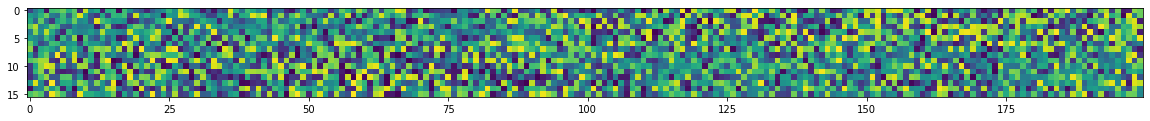

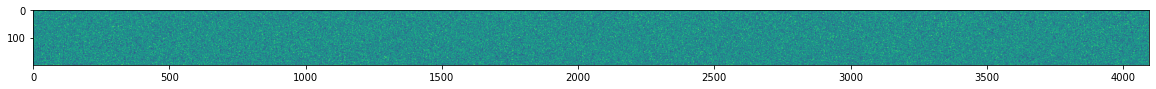

Block regularizer 0.44439148902893066


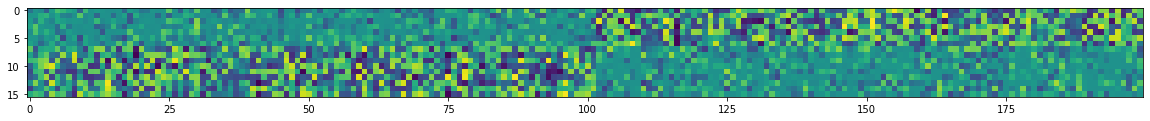

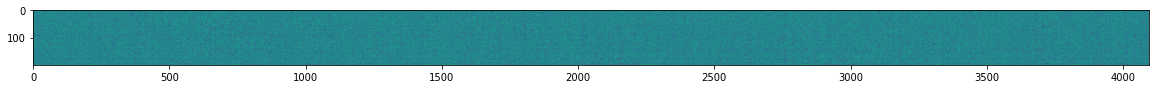

Train Loss: 0.1179, Train Acc: 14.53
Val Loss: 0.0558, Val Acc: 33.96
1
Block regularizer 0.3147695064544678


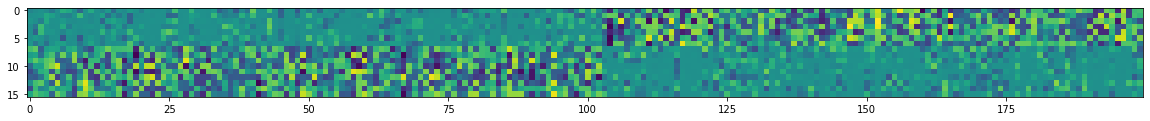

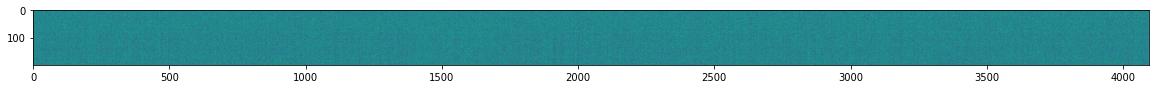

Block regularizer 0.23993563652038574


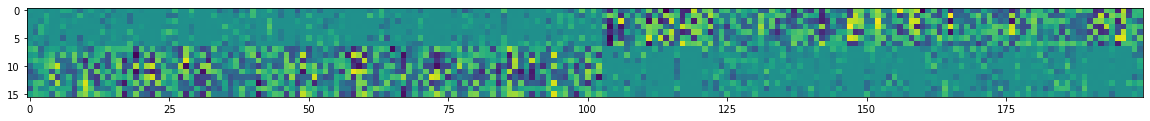

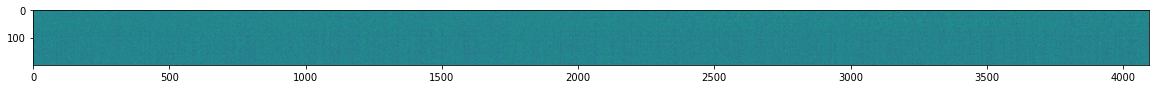

Train Loss: 0.0709, Train Acc: 28.91
Val Loss: 0.0311, Val Acc: 60.16
2
Block regularizer 0.2153301239013672


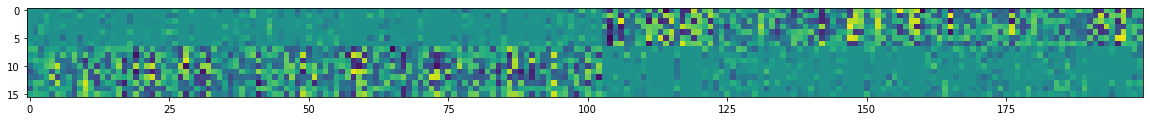

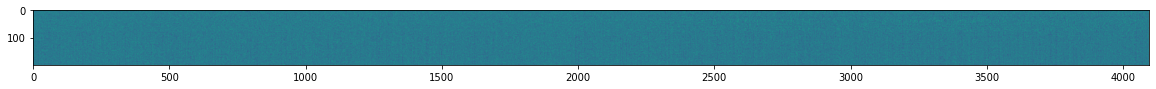

Block regularizer 0.19303548336029053


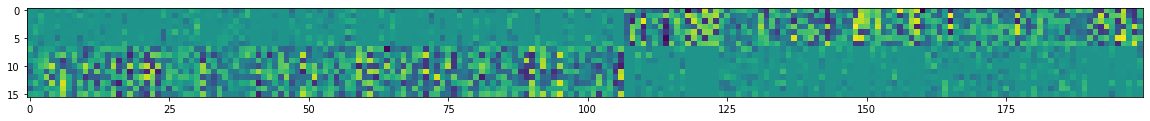

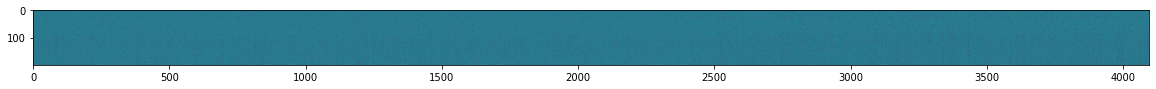

Train Loss: 0.0548, Train Acc: 41.51
Val Loss: 0.0333, Val Acc: 65.52
3
Block regularizer 0.18259406089782715


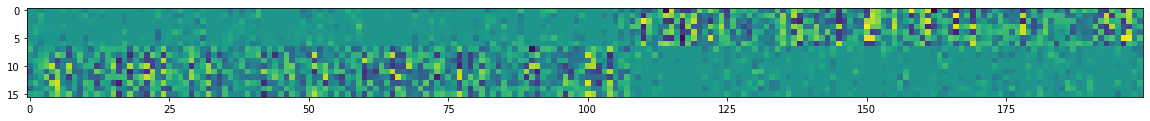

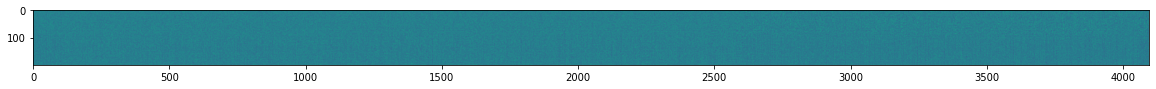

Block regularizer 0.17084932327270508


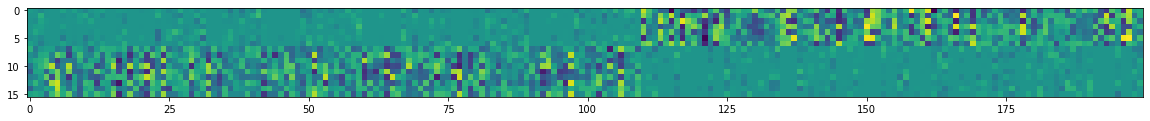

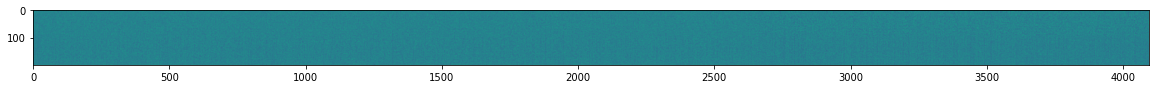

Train Loss: 0.0468, Train Acc: 46.88
Val Loss: 0.0205, Val Acc: 67.60
4
Block regularizer 0.16432929039001465


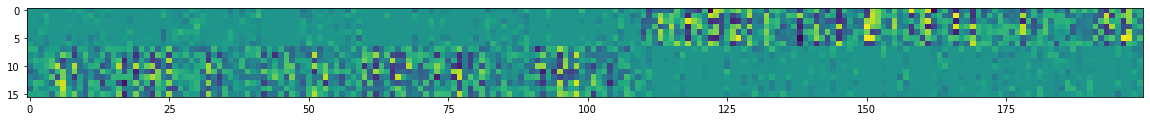

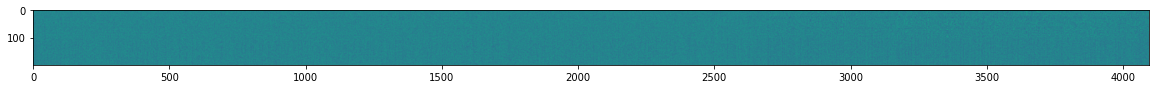

Block regularizer 0.15703952312469482


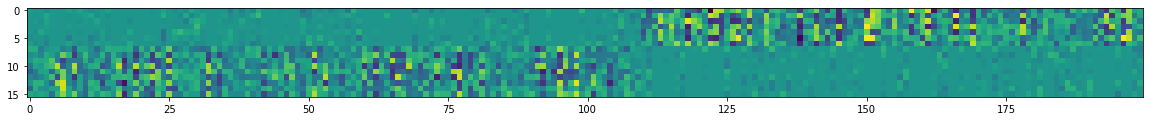

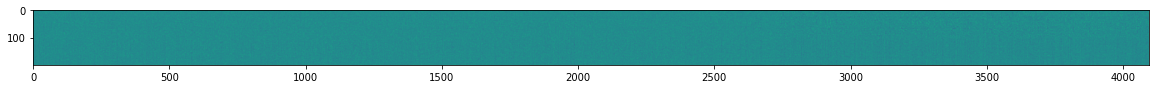

Train Loss: 0.0424, Train Acc: 51.56
Val Loss: 0.0194, Val Acc: 76.51
5
Block regularizer 0.153855562210083


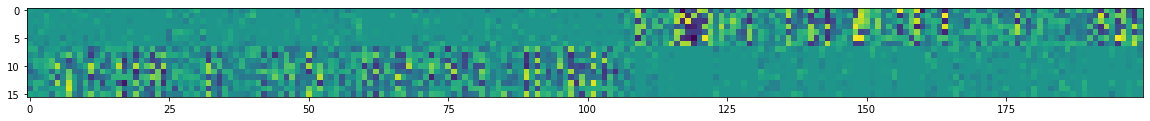

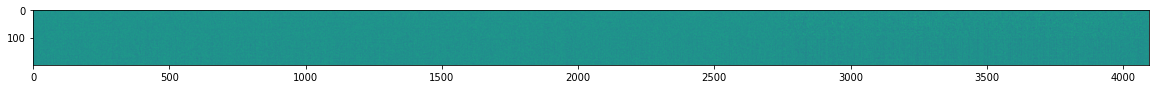

Block regularizer 0.14766573905944824


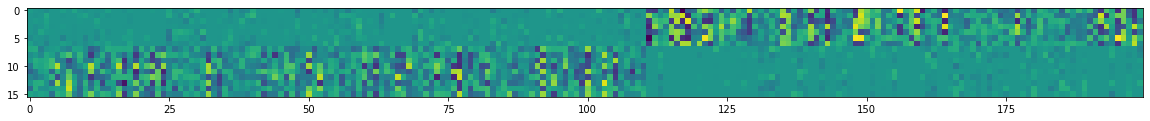

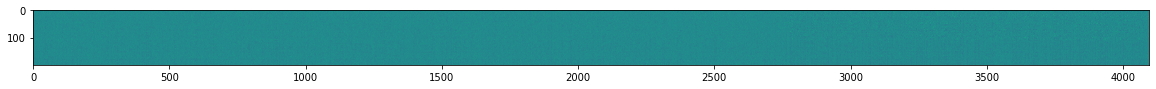

Train Loss: 0.0381, Train Acc: 56.67
Val Loss: 0.0250, Val Acc: 76.15
6
Block regularizer 0.1444615125656128


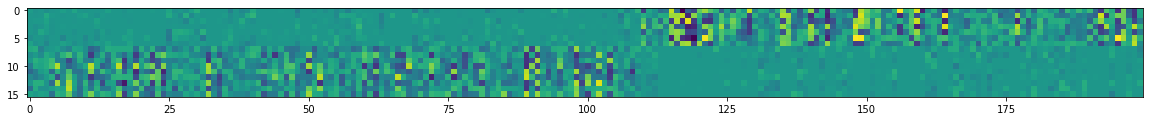

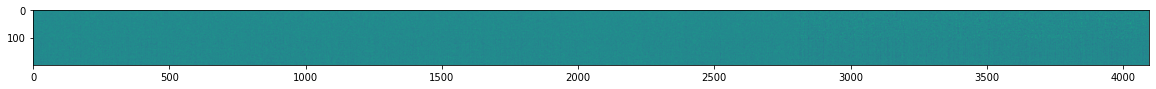

Block regularizer 0.13855886459350586


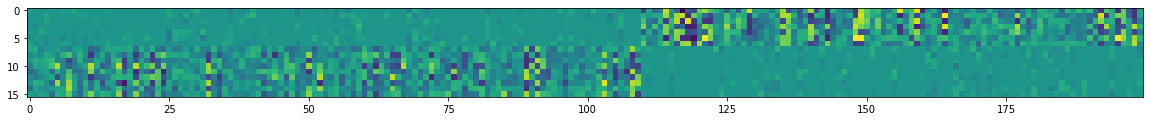

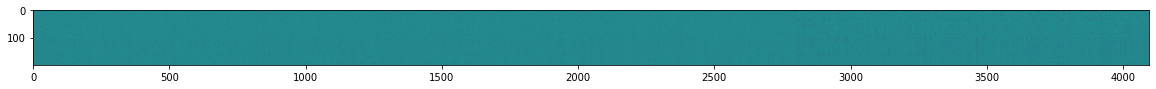

Train Loss: 0.0350, Train Acc: 60.00
Val Loss: 0.0289, Val Acc: 79.69
7
Block regularizer 0.13573908805847168


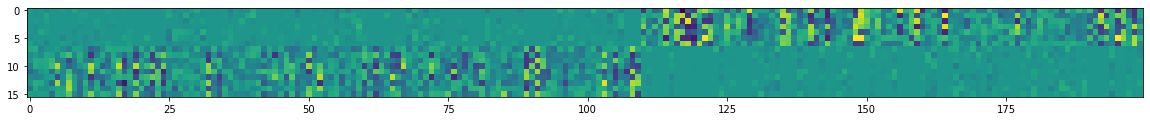

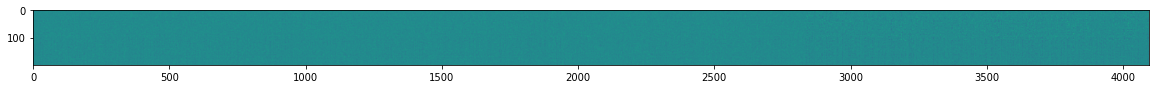

Block regularizer 0.13187789916992188


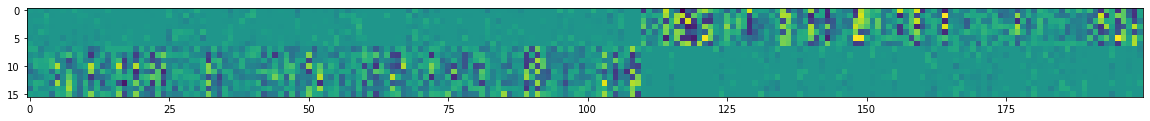

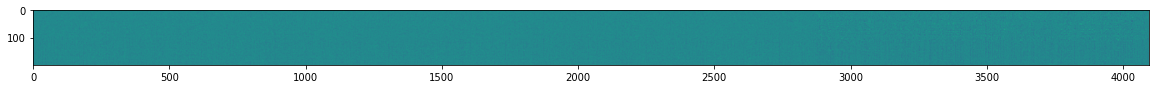

Train Loss: 0.0318, Train Acc: 64.11
Val Loss: 0.0175, Val Acc: 84.01
8
Block regularizer 0.12998056411743164


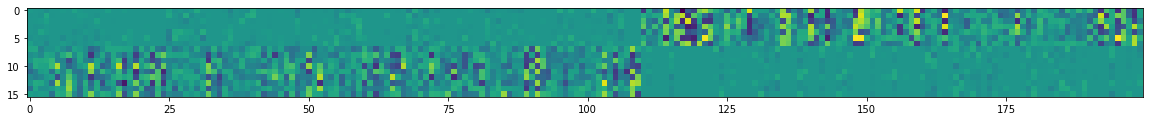

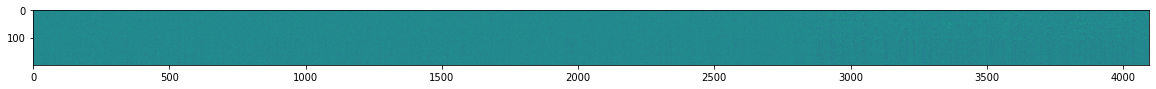

Block regularizer 0.12822556495666504


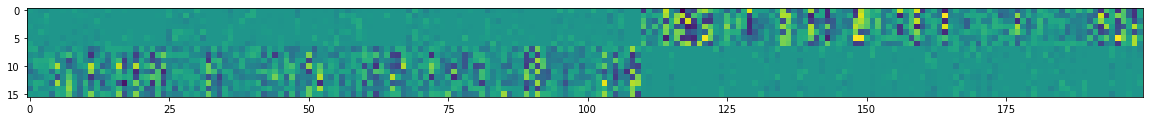

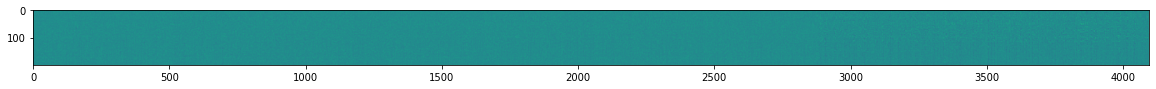

Train Loss: 0.0300, Train Acc: 65.62
Val Loss: 0.0152, Val Acc: 85.00
9
Block regularizer 0.1251540184020996


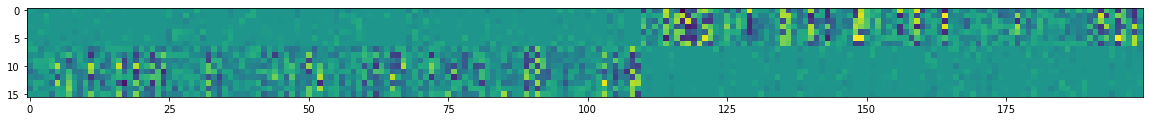

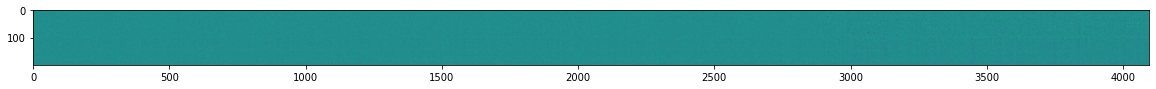

Block regularizer 0.12300348281860352


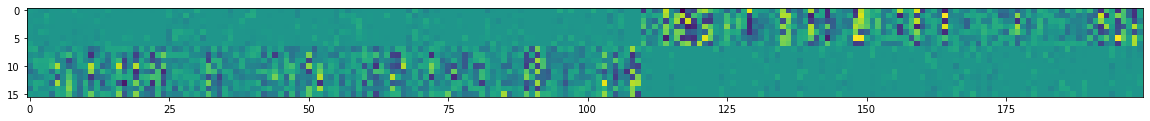

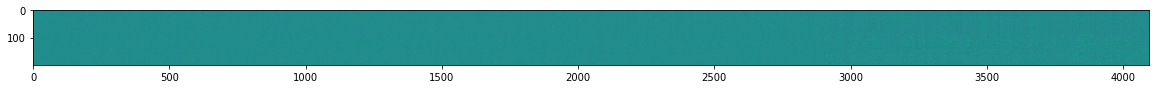

Train Loss: 0.0301, Train Acc: 66.25
Val Loss: 0.0137, Val Acc: 89.90
10
Block regularizer 0.1222989559173584


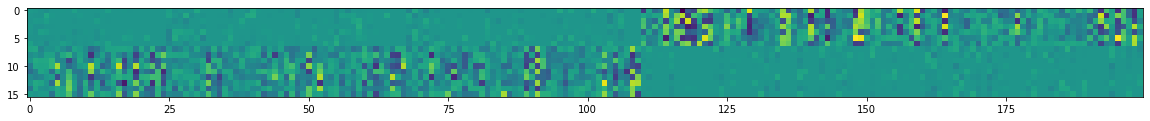

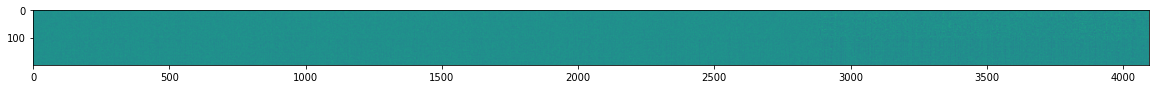

Block regularizer 0.11844348907470703


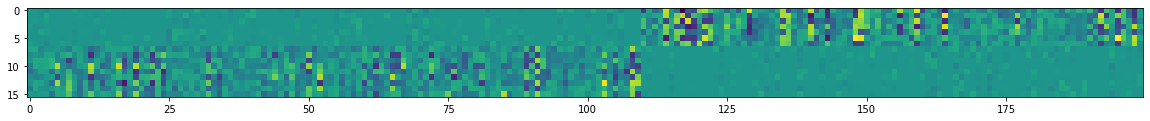

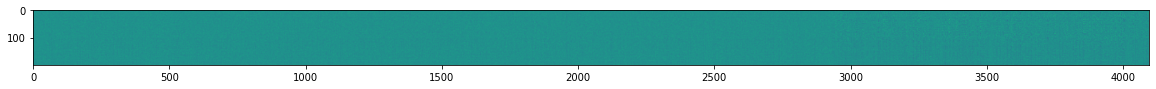

Train Loss: 0.0250, Train Acc: 72.19
Val Loss: 0.0225, Val Acc: 85.21
11
Block regularizer 0.11886405944824219


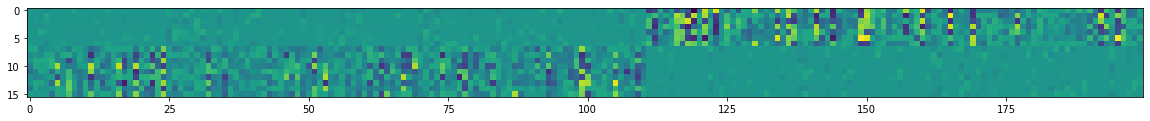

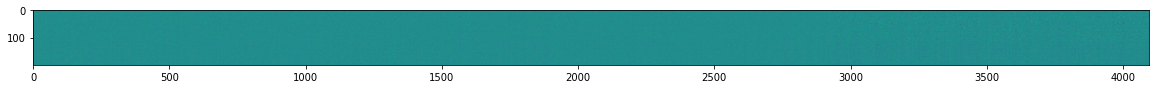

Block regularizer 0.11668193340301514


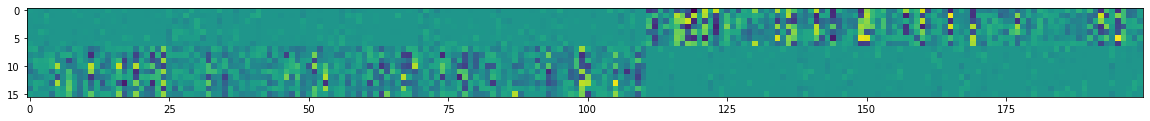

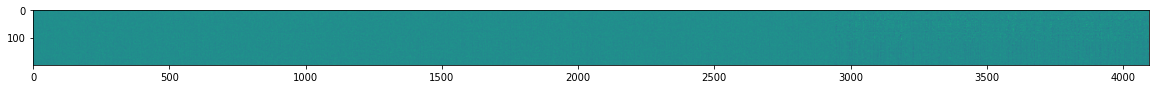

Train Loss: 0.0263, Train Acc: 70.47
Val Loss: 0.0109, Val Acc: 89.90
12
Block regularizer 0.11454319953918457


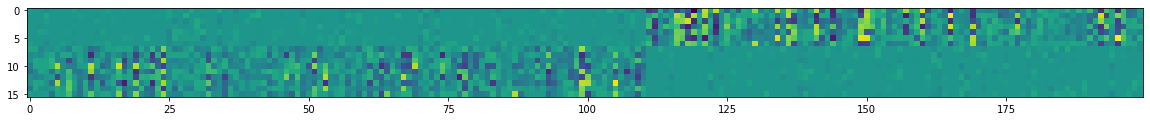

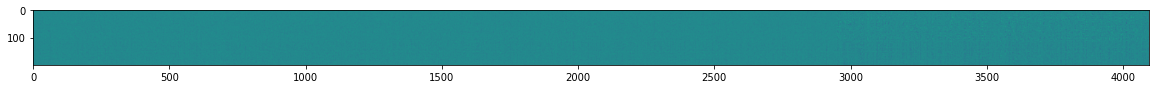

Block regularizer 0.11271166801452637


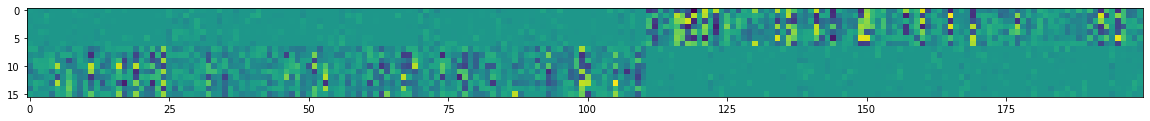

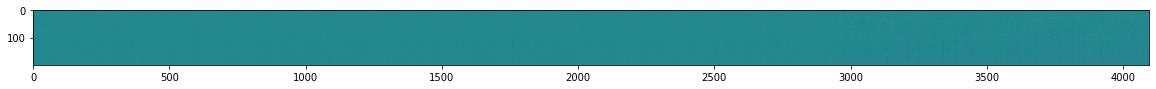

Train Loss: 0.0248, Train Acc: 73.33
Val Loss: 0.0126, Val Acc: 89.32
13
Block regularizer 0.11158990859985352


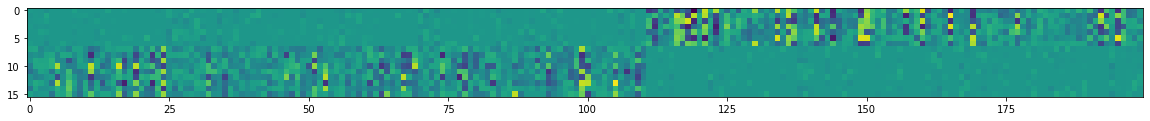

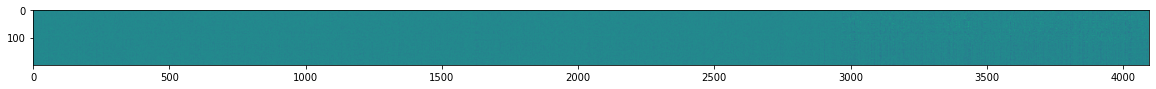

Block regularizer 0.10995566844940186


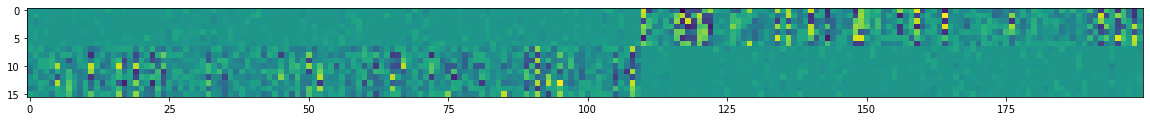

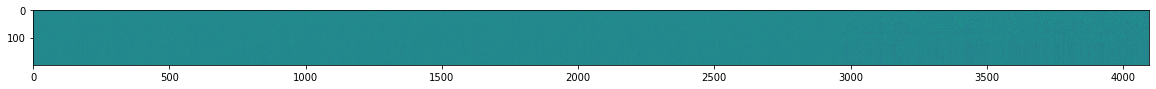

Train Loss: 0.0240, Train Acc: 74.69
Val Loss: 0.0069, Val Acc: 92.81
14
Block regularizer 0.10971474647521973


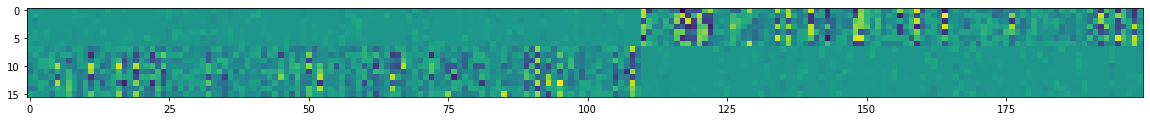

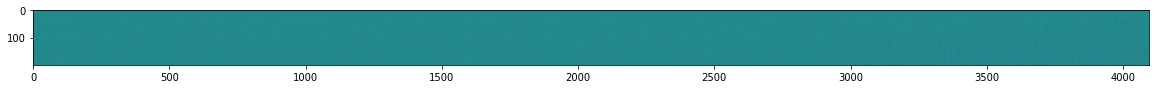

Block regularizer 0.10862517356872559


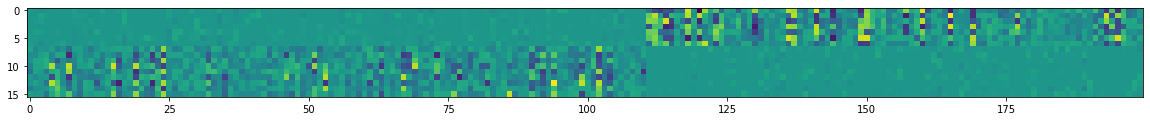

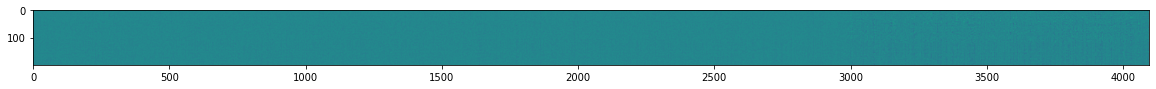

Train Loss: 0.0217, Train Acc: 77.66
Val Loss: 0.0149, Val Acc: 91.20
15
Block regularizer 0.10662341117858887


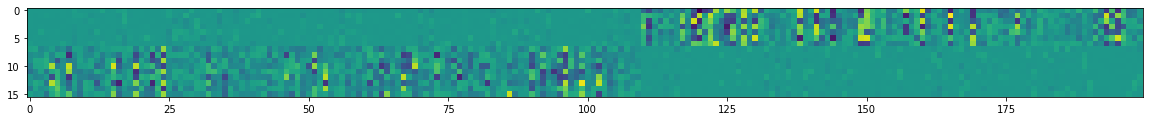

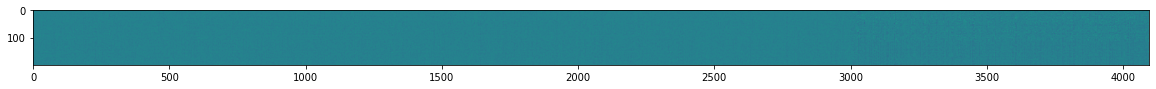

Block regularizer 0.10429525375366211


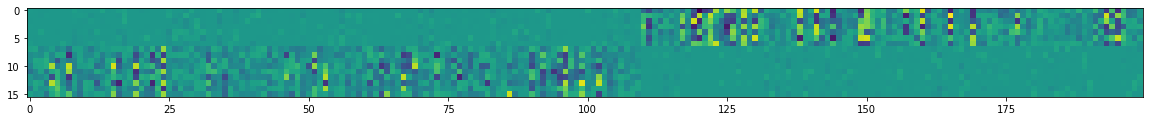

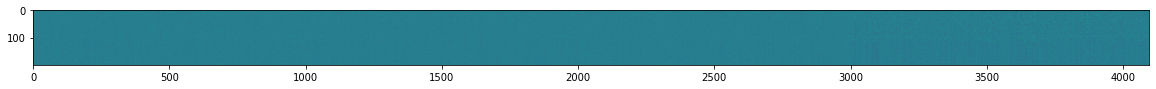

Train Loss: 0.0218, Train Acc: 76.72
Val Loss: 0.0070, Val Acc: 93.07
16
Block regularizer 0.10213685035705566


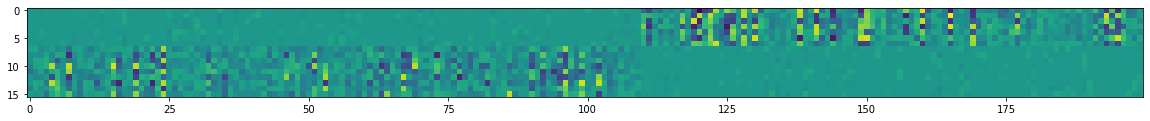

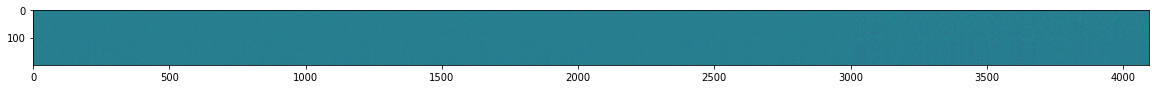

Block regularizer 0.10010576248168945


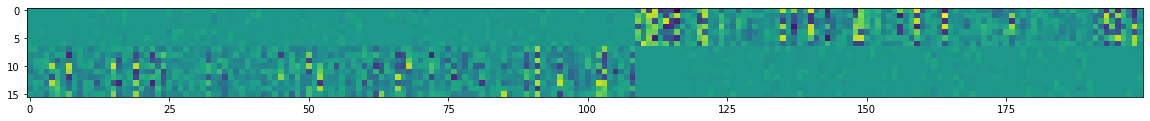

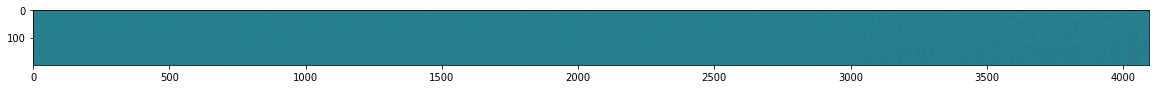

Train Loss: 0.0210, Train Acc: 78.23
Val Loss: 0.0108, Val Acc: 91.61
17
Block regularizer 0.10062289237976074


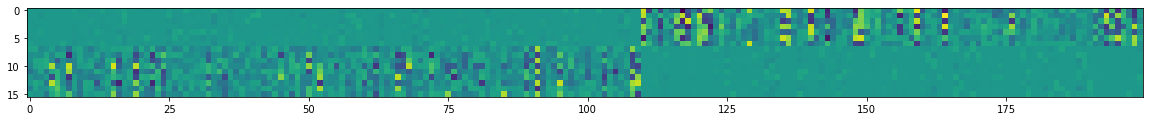

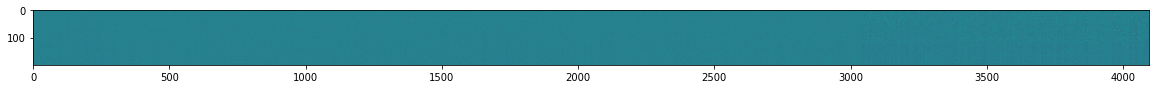

Block regularizer 0.0976858139038086


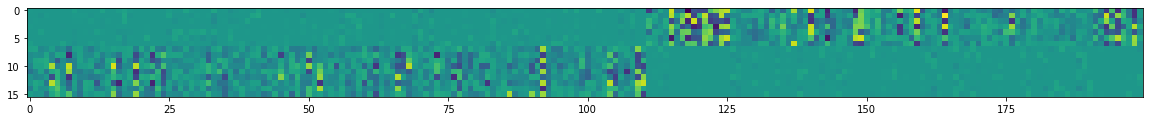

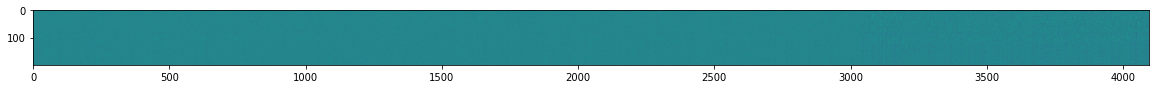

Train Loss: 0.0186, Train Acc: 81.61
Val Loss: 0.0064, Val Acc: 93.39
18
Block regularizer 0.09495401382446289


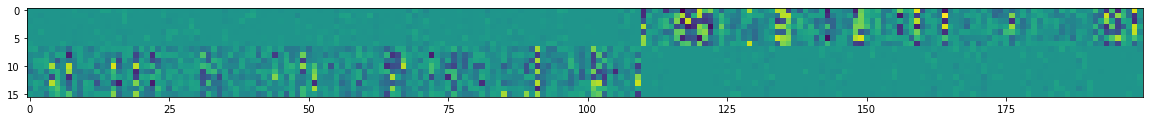

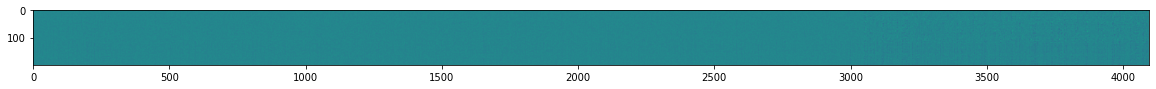

Block regularizer 0.09186673164367676


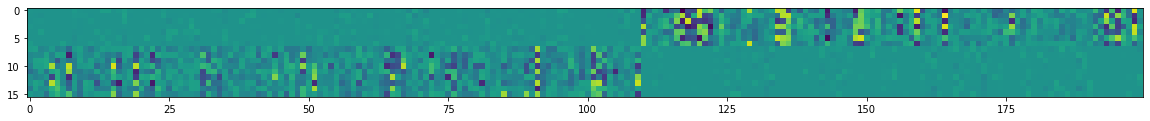

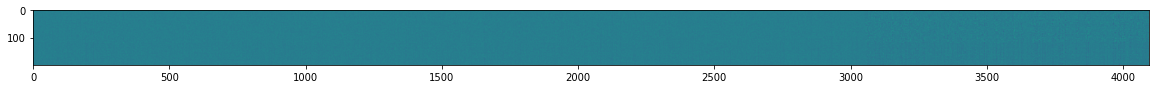

Train Loss: 0.0163, Train Acc: 83.80
Val Loss: 0.0101, Val Acc: 93.28
19
Block regularizer 0.08966505527496338


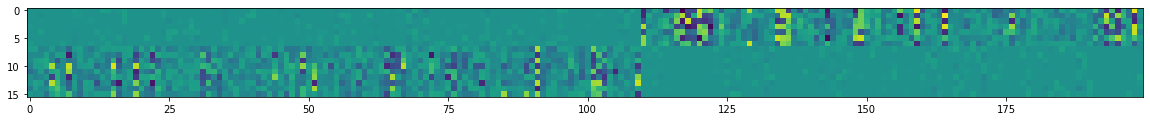

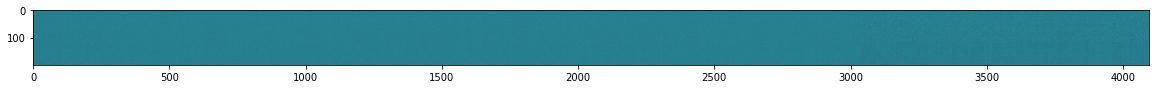

Block regularizer 0.09025895595550537


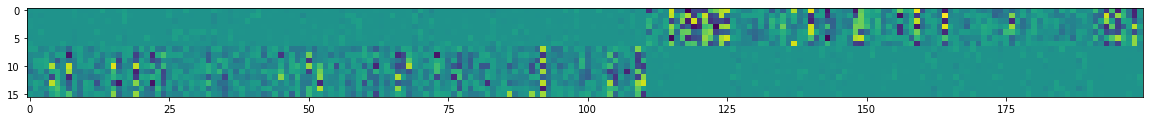

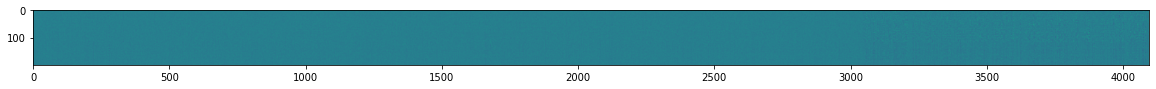

Train Loss: 0.0179, Train Acc: 83.91
Val Loss: 0.0056, Val Acc: 94.48
20
Block regularizer 0.08994364738464355


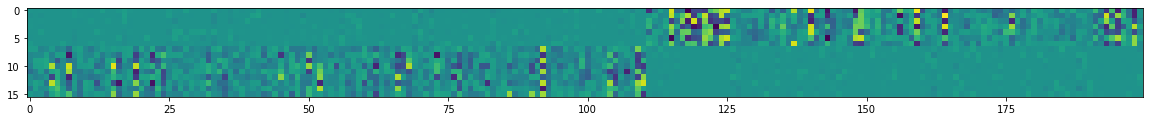

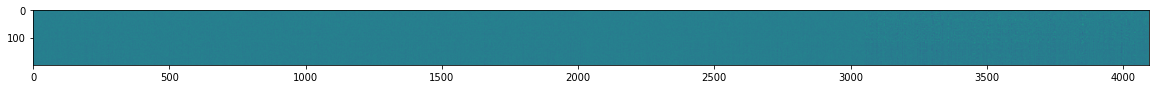

Block regularizer 0.08884680271148682


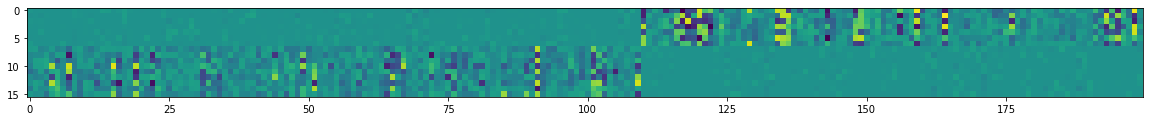

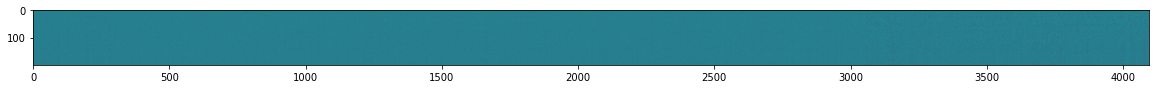

Train Loss: 0.0165, Train Acc: 84.74
Val Loss: 0.0075, Val Acc: 94.58
21
Block regularizer 0.08722567558288574


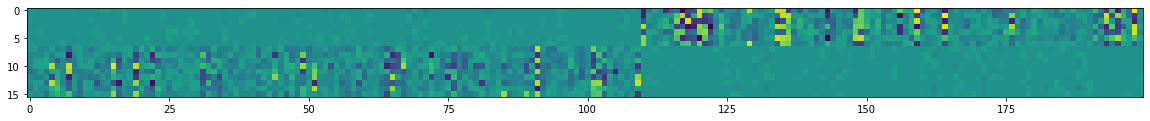

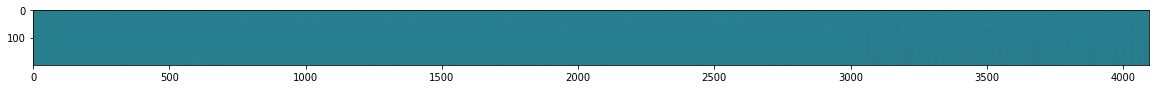

Block regularizer 0.08632659912109375


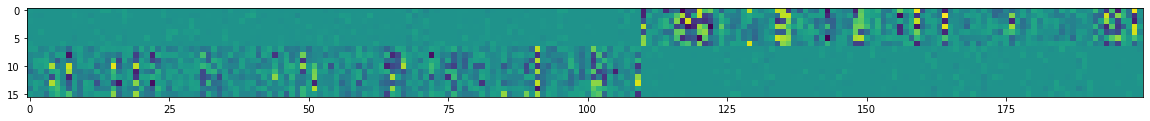

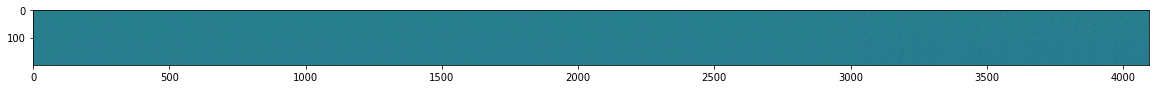

Train Loss: 0.0159, Train Acc: 84.48
Val Loss: 0.0088, Val Acc: 93.39
22
Block regularizer 0.08370852470397949


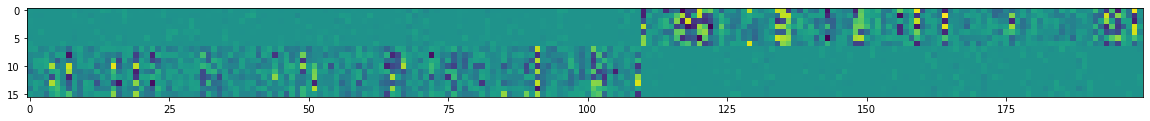

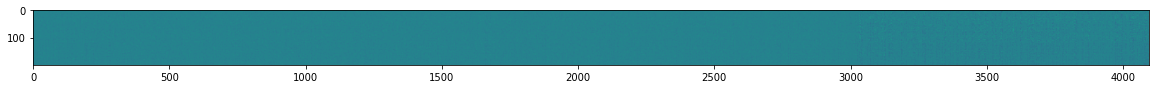

Block regularizer 0.08150005340576172


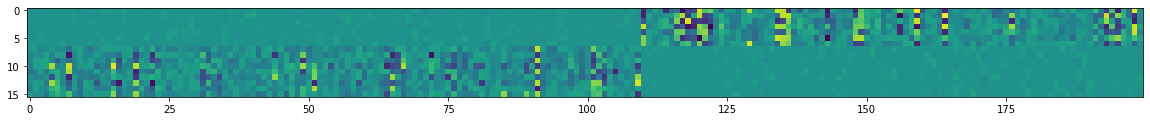

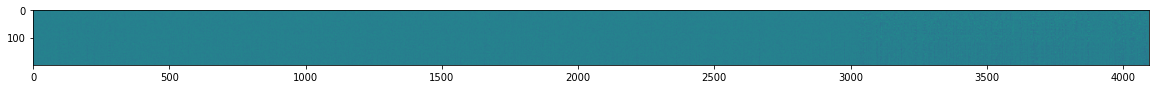

Train Loss: 0.0143, Train Acc: 85.52
Val Loss: 0.0063, Val Acc: 95.78
23
Block regularizer 0.08124363422393799


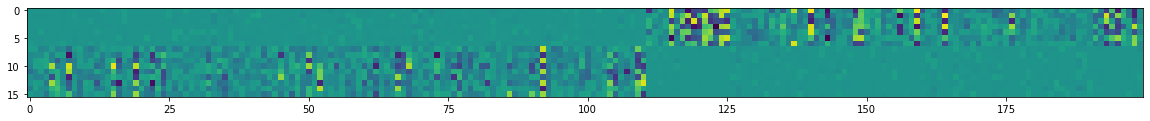

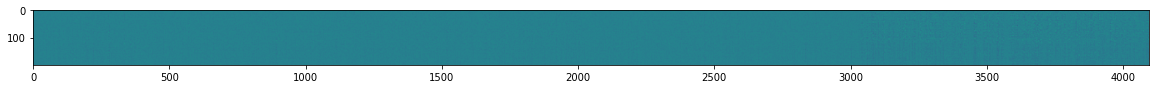

Block regularizer 0.08195638656616211


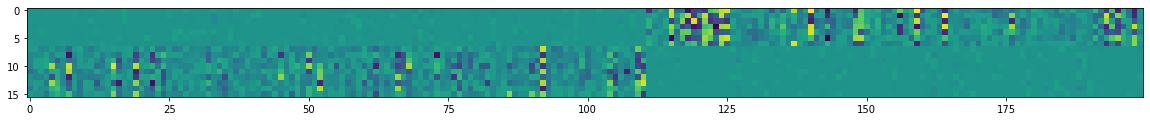

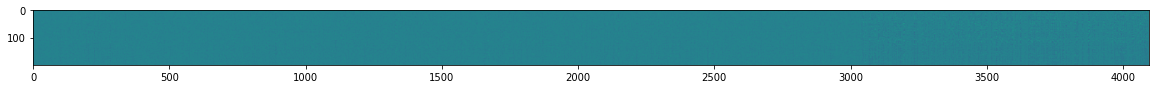

Train Loss: 0.0143, Train Acc: 86.46
Val Loss: 0.0029, Val Acc: 97.66
24
Block regularizer 0.08166217803955078


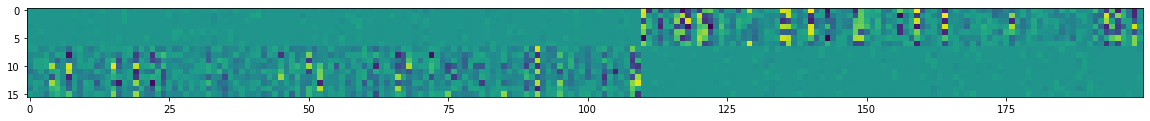

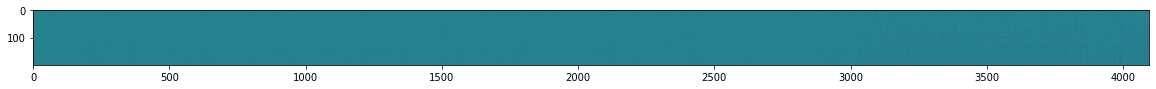

Block regularizer 0.08043456077575684


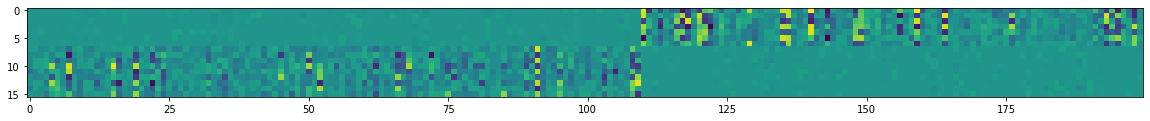

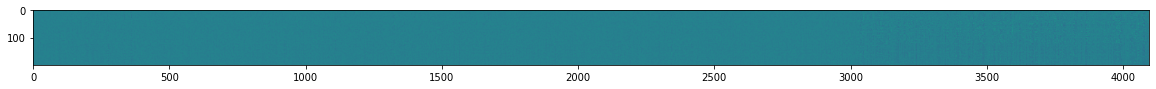

Train Loss: 0.0143, Train Acc: 86.09
Val Loss: 0.0062, Val Acc: 95.57
25
Block regularizer 0.07922542095184326


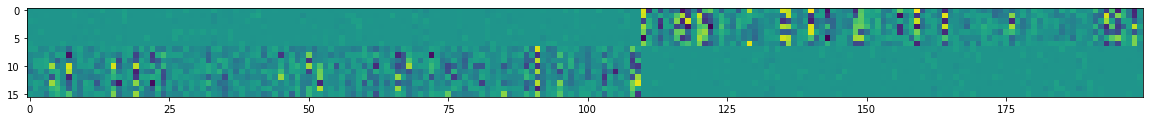

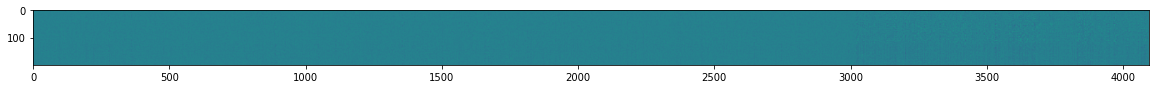

Block regularizer 0.07840394973754883


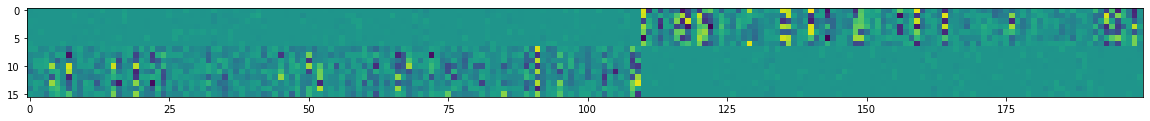

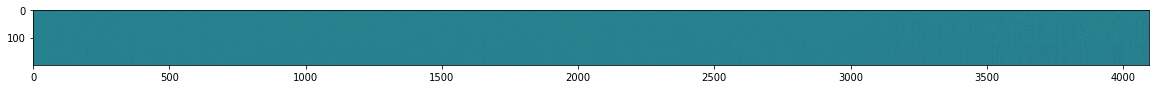

Train Loss: 0.0127, Train Acc: 88.65
Val Loss: 0.0096, Val Acc: 94.69
26
Block regularizer 0.07845330238342285


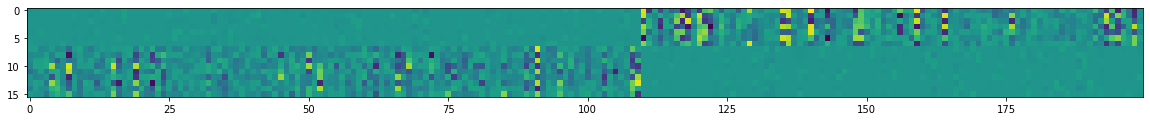

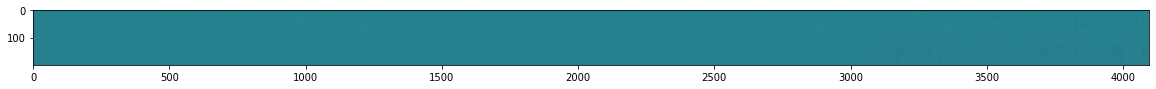

Block regularizer 0.07898712158203125


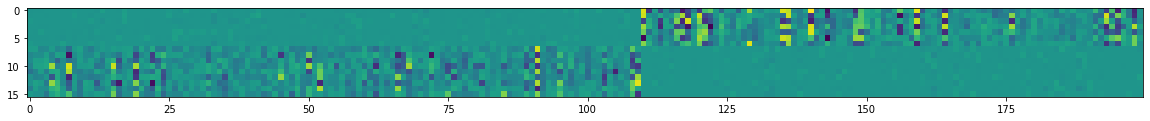

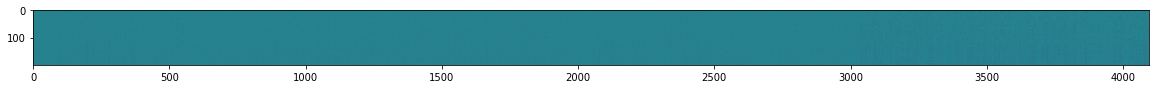

Train Loss: 0.0150, Train Acc: 86.41
Val Loss: 0.0070, Val Acc: 94.95
27
Block regularizer 0.07941782474517822


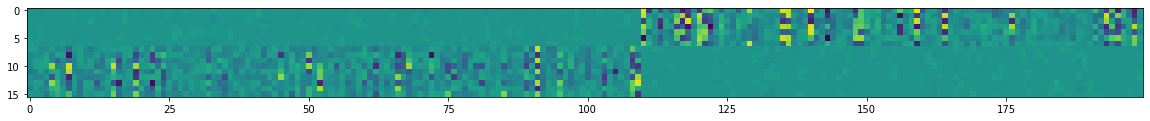

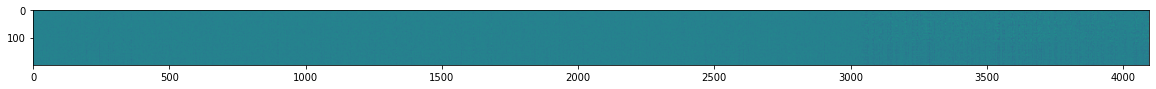

Block regularizer 0.07851886749267578


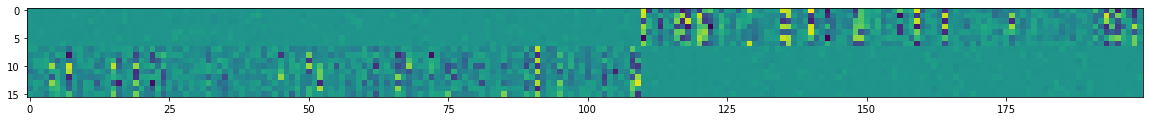

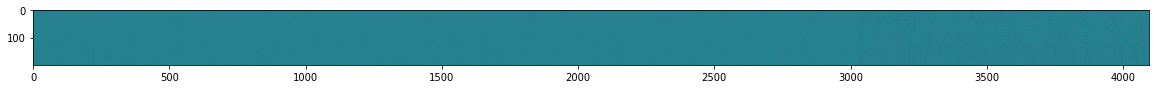

Train Loss: 0.0149, Train Acc: 86.72
Val Loss: 0.0047, Val Acc: 97.19
28
Block regularizer 0.07899904251098633


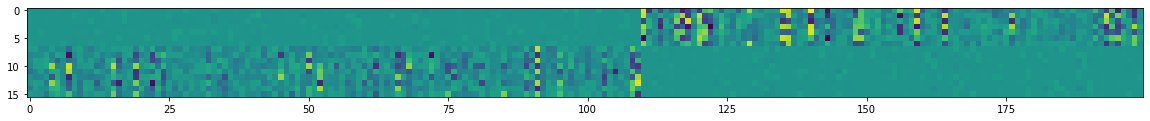

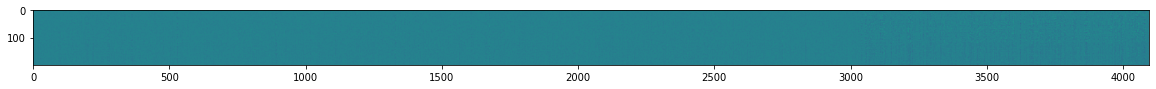

Block regularizer 0.07769739627838135


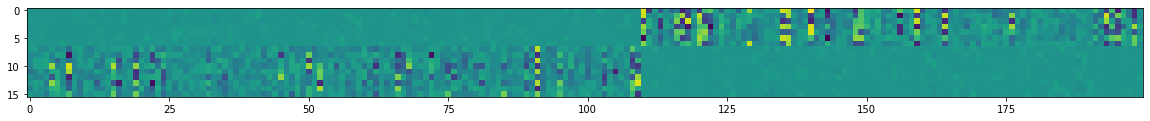

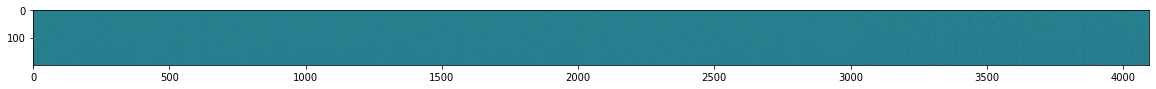

Train Loss: 0.0123, Train Acc: 88.85
Val Loss: 0.0044, Val Acc: 97.14
29
Block regularizer 0.07792282104492188


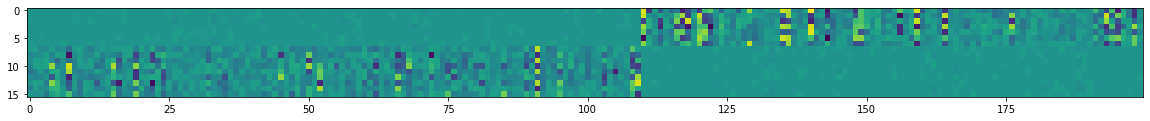

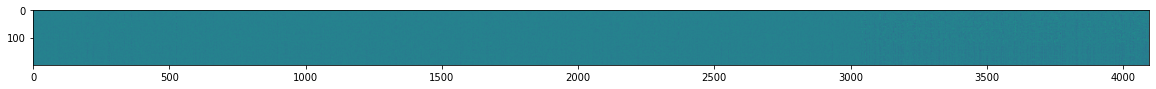

Block regularizer 0.0757826566696167


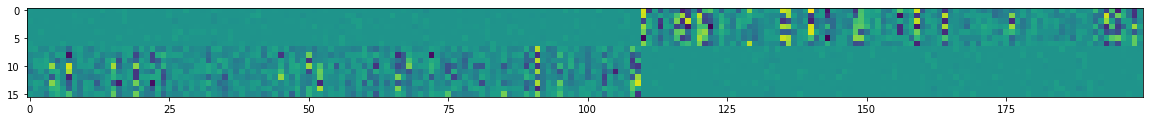

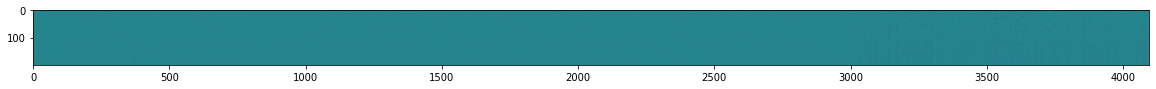

Train Loss: 0.0141, Train Acc: 87.86
Val Loss: 0.0079, Val Acc: 96.77
11.736048559347788 minutes


In [17]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy, br = [], [], []
start = time.time()
for epoch in range(n_epochs):
    print(epoch)
    train_epoch_loss, train_epoch_accuracy, block_reg = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    br.append(block_reg)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    torch.save(vgg16, 'vgg16disen_e'+str(epoch)+'.pt')
end = time.time()
print((end-start)/60, 'minutes')

In [18]:
#find activations for images


class SaveOutput:
    def __init__(self):
        self.outputs = None
        
    def __call__(self, module, module_in, module_out):
        self.outputs = module_out.detach().cpu().numpy()

hook = SaveOutput()
vgg16.classifier[3].register_forward_hook(hook)

weighted_images_pos = np.zeros((200, *data[0].shape))
weighted_images_neg = np.zeros((200, *data[0].shape))
act_max = np.zeros(200)

for i, data in enumerate(testloader):
    data, target = data[0], data[1]
    data = data.to(device)
    output = vgg16(data)
    data = data.detach().cpu().numpy()

    batch_ext = np.repeat(data[:, np.newaxis, :, :], 200, axis=1)
    weighted_images_pos += np.average(batch_ext * np.expand_dims((hook.outputs > 0) * hook.outputs, axis=(2, 3, 4)), axis=0)
    weighted_images_neg += np.average(batch_ext * np.expand_dims((hook.outputs < 0) * -hook.outputs, axis=(2, 3, 4)), axis=0)


    act_max = np.max(np.stack([act_max, np.max(hook.outputs, axis=0)], axis=0), axis=0)

weighted_images_pos /= np.expand_dims(np.max(weighted_images_pos, axis=(1, 2, 3)), axis=(1, 2, 3))
weighted_images_neg /= np.expand_dims(np.max(weighted_images_neg, axis=(1, 2, 3)), axis=(1, 2, 3))

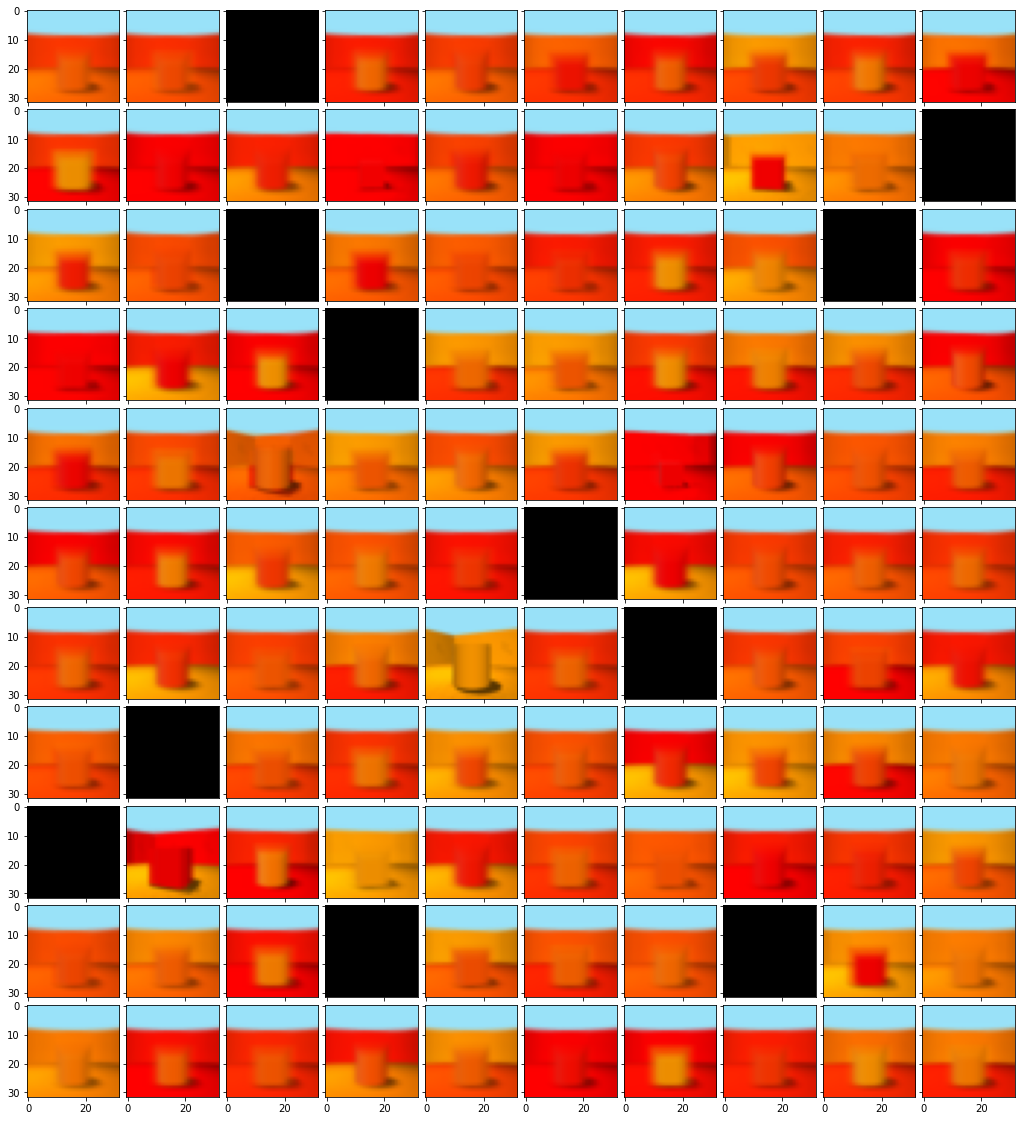

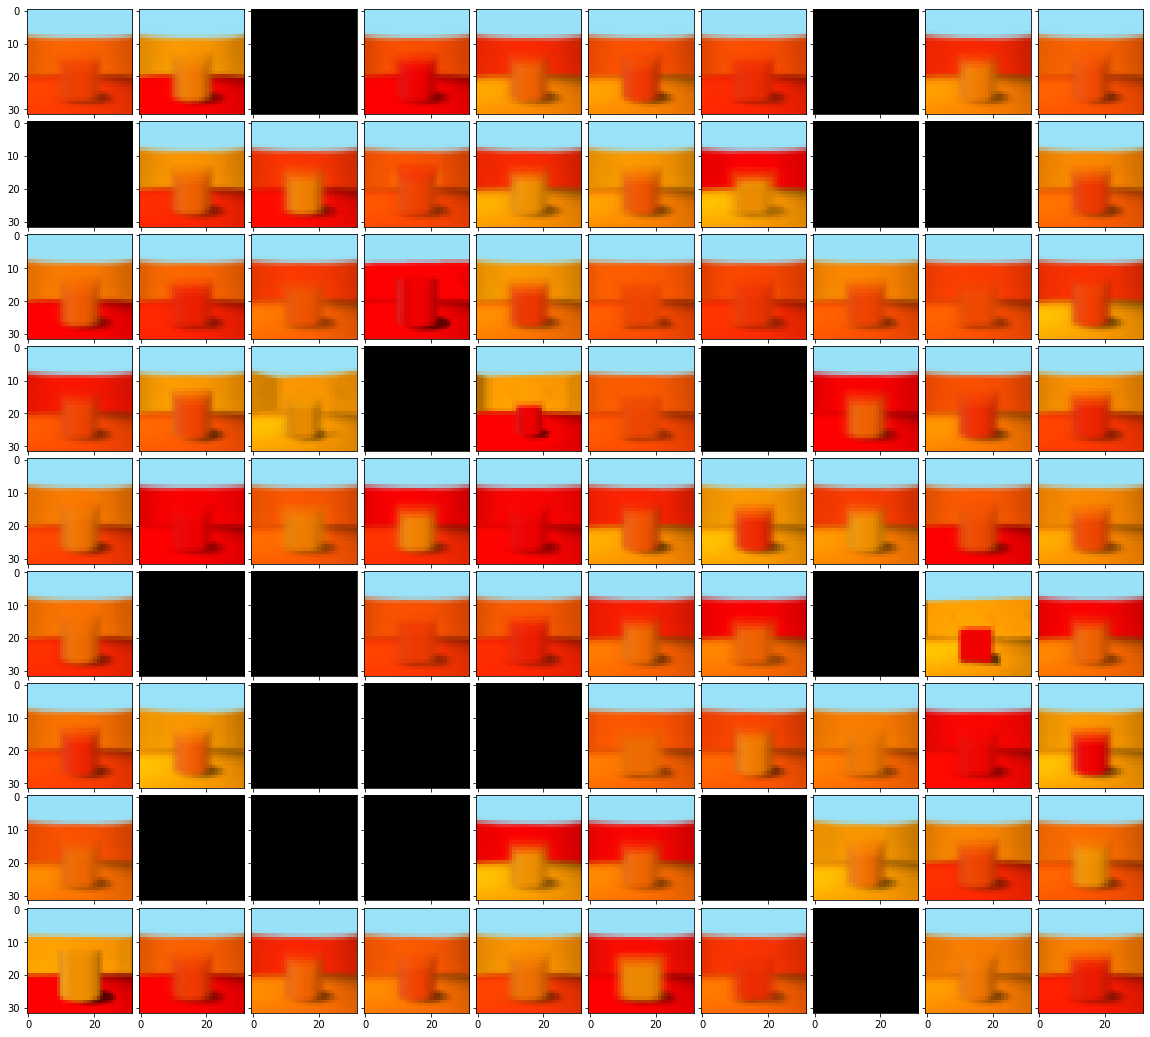

In [22]:
from mpl_toolkits.axes_grid1 import ImageGrid

blocks = compute_layer_blocks_in(vgg16.classifier[6], ncc)
for c in range(ncc):
    fig = plt.figure(figsize=(20., 20.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(int(np.ceil((blocks==c).sum()/10)), 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )
    #for ax, im in zip(grid, weighted_images_pos*np.expand_dims(blocks==c, axis=(1, 2, 3))):
    for ax, im in zip(grid, weighted_images_pos[blocks==c]):
        ax.imshow(im.transpose(1, 2, 0))

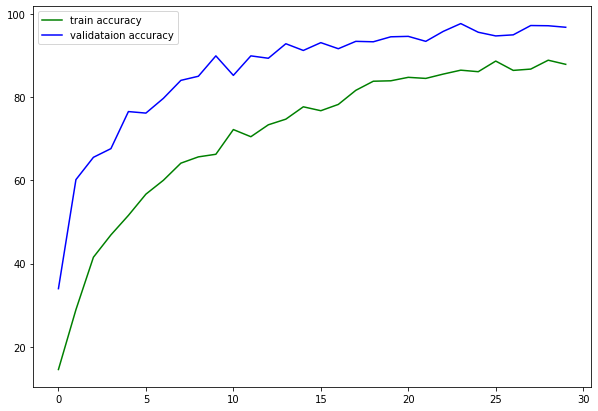

In [23]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

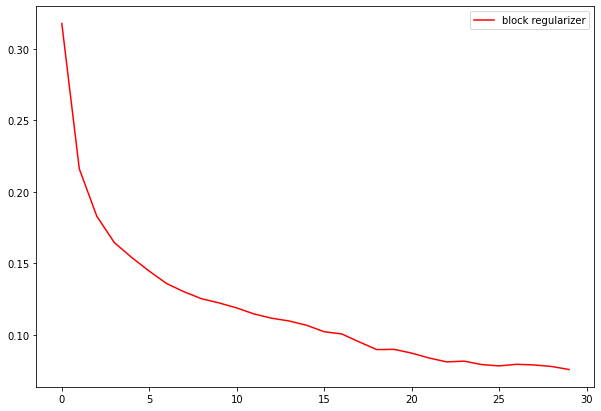

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(br, color='red', label='block regularizer')
plt.legend()
plt.savefig('br.png')
plt.show()

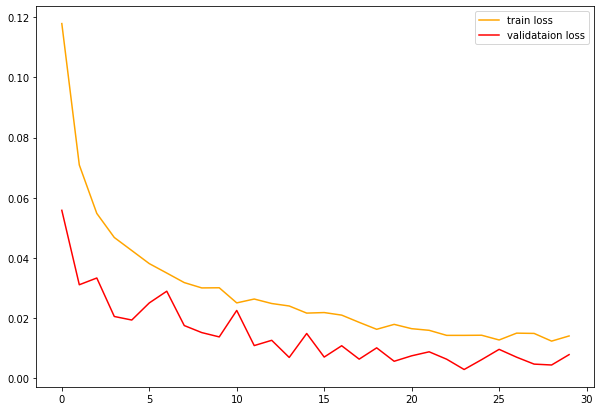

In [25]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

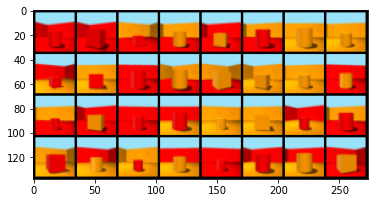

Image shape: torch.Size([3, 32, 32])
tensor([14, 15, 11,  8, 13, 10,  0,  0,  7,  3, 14,  8,  9,  1,  0, 12, 10, 13,
        14,  6,  0,  1,  6, 10,  3,  4,  2,  4, 14,  6,  4, 13])


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from col_mnist import ColMNIST

plt.rcParams["axes.grid"] = False
device = "cuda" if torch.cuda.is_available() else "cpu"

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
data, target = dataiter.next()
target = target_vec_to_class(target)
imshow(torchvision.utils.make_grid(data))
img_shape = data[0].shape
print("Image shape: {}".format(img_shape))
print(target)

In [27]:
from explainn_code.grab_functions import db_from_dat_with_labels, write_pic_as_sets

tail = []
head = []

for i, data in enumerate(testloader):
    data, target = data[0], data[1]
    target = target_vec_to_class(target)
    data = data.to(device)
    target = target.to(device)
    output = vgg16(data).cpu()

    head.append(vgg16.classifier[6].detach().cpu().numpy())
    tail.append(target.detach().cpu().numpy())
head = np.concatenate(head)
tail = np.concatenate(tail)

ModuleAttributeError: 'DisentangledLinear' object has no attribute 'detach'

In [ ]:
write_pic_as_sets(head, "vgg_head_blocked_v1.data")

In [ ]:
write_pic_as_sets(tail "tail_v1.dat")

In [ ]:
!conda info --envs